<h3 style="text-align: center;">
Emory University - Department of Economics
</h3>

<h4 style="text-align: center;">
Prof. Maria Arbatskaya, Ph.D.
</h4>

<h5 style="text-align: center;">
Student: Fareed Wajid Khan 

Date: December 11th, 2023
</h5>

### Table of contents

0. Packages and some specific settings
1. Access Keepa API
2. Amazon categories
3. Product history query
4. Variation query
5. Top sellers query

### 0. Packages and some specific settings

In [2]:
pip install aiohttp

Note: you may need to restart the kernel to use updated packages.


In [3]:
pip install tqdm

Note: you may need to restart the kernel to use updated packages.


In [4]:
pip install keepa

Note: you may need to restart the kernel to use updated packages.


In [5]:
pip install asyncio

Note: you may need to restart the kernel to use updated packages.


In [6]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import aiohttp
import tqdm
import keepa
import os
import asyncio

#plt.style.use('whitegrid') # Matplotlib style
plt.rcParams['figure.figsize'] = [6, 3] # Matplotlib figure size

# Set working directory (change to your own)
path = "/Users/fareedkhan/Documents/Thesis"
os.chdir(path)

# Data Organization & Preprocessing

In [7]:
import pandas as pd

# Import Data
original_data = pd.read_csv("Keepa Feb 13.csv")
modified_data = original_data.drop(['Locale', 'Image'], axis =1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Parsing Sales rank
def parse_sales_rank(row):
    if isinstance(row, str):
        parts = row.split('|')
        absolute_rank = parts[0].strip()
        top_1_percent = parts[1].strip()

        category_part = parts[-1].strip()
        category = category_part.split(';')[0].strip()

        return pd.Series([absolute_rank, top_1_percent, category])
    else:
        return pd.Series([None,None,None])

#S Split Subcategory sales rank for processing
new_columns = original_data['Sales Rank: Subcategory Sales Ranks'].apply(parse_sales_rank)
new_columns.columns = ['Absolute Rank', 'Top 1 Percent', 'Category']
modified_data = pd.concat([modified_data, new_columns], axis=1)


# Rempve unnessesary data
modified_data = modified_data.drop(['Sales Rank: Subcategory Sales Ranks'], axis =1)
modified_data = modified_data.drop(['Sales Rank: Reference'], axis =1)
modified_data = modified_data.drop(['Top 1 Percent'], axis =1)

# Convert Absolute Rank into numeric
modified_data['Absolute Rank'] = modified_data['Absolute Rank'].str.strip('# ')
modified_data['Absolute Rank'] = pd.to_numeric(modified_data['Absolute Rank'],errors='coerce')

#Count Variation ASIN
modified_data['Variation ASINs'] = modified_data['Variation ASINs'].fillna("")
modified_data['Variation ASIN Count'] = modified_data['Variation ASINs'].apply(lambda x: len(x.split(',')))


#modified_data.head()
#modified_data.to_csv('Modified.csv')


## Data Prep (Converting Data & One-Hot Encoding)

In [41]:
import statsmodels

# Categorizing Data
categorical_column_data = ['Buy Box Seller', 'Buy Box Used Seller', 'Buy Box Used: Condition', 'Categories: Root', 'Categories: Sub', 'Categories: Tree', 'ASIN', 'Product Codes: EAN', 'Product Codes: UPC', 'Product Codes: PartNumber', 'Parent ASIN', 'Variation ASINs', 'Freq. Bought Together', 'Type', 'Manufacturer', 'Brand', 'Product Group', 'Model', 'Variation Attributes', 'Color', 'Size', 'Edition', 'Format', 'Author', 'Contributors', 'Binding', 'Languages', 'Hazardous Materials', 'Category']
numeric_column_data = ['Sales Rank: Current', 'Amazon: 90 days OOS', 'New: 90 days OOS', 'Used: 90 days OOS', 'Sales Rank: 90 days avg.', 'Sales Rank: Drops last 90 days', 'Bought in past month','Reviews: Review Count', 'Buy Box 🚚: Current', 'Buy Box 🚚: 90 days avg.', 'Buy Box 🚚: Stock', 'Amazon: Current', 'Amazon: 90 days avg.', 'New: Current', 'New: 90 days avg.','New, 3rd Party FBA: Current','New: 90 days avg.','New, 3rd Party FBA: 90 days avg.', 'FBA Pick&Pack Fee', 'Referral Fee based on current Buy Box price', 'New, 3rd Party FBA: Current', 'New, 3rd Party FBA: 90 days avg.', 'New, Prime exclusive: Current', 'New, Prime exclusive: 90 days avg.', 'Lightning Deals: Current', 'Buy Box Used 🚚: Current', 'Buy Box Used 🚚: 90 days avg.', 'Used: Current', 'Used: 90 days avg.', 'Used, like new 🚚: Current', 'Used, like new 🚚: 90 days avg.', 'Used, very good 🚚: Current', 'Used, very good 🚚: 90 days avg.', 'Used, good 🚚: Current', 'Used, good 🚚: 90 days avg.', 'Used, acceptable 🚚: Current', 'Used, acceptable 🚚: 90 days avg.', 'Warehouse Deals: Current', 'Warehouse Deals: 90 days avg.', 'List Price: Current', 'List Price: 90 days avg.', 'Rental: Current', 'Rental: 90 days avg.', 'eBay New 🚚: Current', 'eBay New 🚚: 90 days avg.', 'eBay Used 🚚: Current', 'eBay Used 🚚: 90 days avg.', 'New Offer Count: Current', 'New Offer Count: 90 days avg.', 'Count of retrieved live offers: New, FBM', 'Used Offer Count: Current', 'Used Offer Count: 90 days avg.', 'Number of Items', 'Number of Pages', 'Package: Dimension (cm³)', 'Package: Weight (g)', 'Package: Quantity', 'Item: Dimension (cm³)', 'Item: Weight (g)', 'One Time Coupon: Absolute', 'One Time Coupon: Percentage', 'Absolute Rank', 'Variation ASIN Count']
binary_column_data = ['Buy Box: Is FBA', 'Buy Box: Unqualified', 'Lightning Deals: Upcoming Deal', 'Buy Box Used: Is FBA', 'Categories: Launchpad', 'Adult Product', 'Trade-In Eligible', 'Prime Eligible (Buy Box)', 'Subscribe and Save']

# Fill NA categorical data
for column in categorical_column_data:
    modified_data[column] = modified_data[column].fillna('Missing') 

# Encode categorical data (one hot encoding // high dimensionality)
df_categorical_encoded = pd.get_dummies(modified_data, columns=categorical_column_data, dtype=int)

#Convert from float to numeric for numeric data
for column in numeric_column_data:
    df_categorical_encoded[column] = pd.to_numeric(df_categorical_encoded[column], errors='coerce') 
    df_categorical_encoded[column].fillna(0)

#Encoding binary data in column to 1/0
for column in binary_column_data:
    df_categorical_encoded[column] = df_categorical_encoded[column].map(lambda x: 1 if x == 'yes' else 0)

#Encode Rating data
df_categorical_encoded['Reviews: Rating'] = pd.to_numeric(df_categorical_encoded['Reviews: Rating'], errors='coerce')

# Convert % data into numeric
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'].str.replace('%', '').astype(float)
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'].fillna(0)
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'] /100

# Convert % data into numeric
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = df_categorical_encoded['Subscribe and Save Coupon: Percentage'].str.replace('%', '', regex=False)
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = pd.to_numeric(df_categorical_encoded['Subscribe and Save Coupon: Percentage'], errors='coerce')
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = df_categorical_encoded['Subscribe and Save Coupon: Percentage']/100
df_categorical_encoded['Subscribe and Save Coupon: Percentage']= df_categorical_encoded['Subscribe and Save Coupon: Percentage'].fillna(0)

# Convert % data into numeric
df_categorical_encoded['Buy Box 🚚: 90 days OOS'] = df_categorical_encoded['Buy Box 🚚: 90 days OOS'].str.replace('%', '', regex=False)
df_categorical_encoded['Buy Box 🚚: 90 days OOS'] = pd.to_numeric(df_categorical_encoded['Buy Box 🚚: 90 days OOS'], errors='coerce')
df_categorical_encoded['Buy Box 🚚: 90 days OOS']= df_categorical_encoded['Buy Box 🚚: 90 days OOS'].fillna(0)

# Encode Time Data
time_column_data = ['Last Price Change', 'Tracking since', 'Listed since', 'Publication Date', 'Release Date']
for column in time_column_data:
    df_categorical_encoded = df_categorical_encoded.drop(column, axis=1)

 
# Remove '$' signs from data
for column in df_categorical_encoded.columns:
    if df_categorical_encoded[column].dtype == object:
        if df_categorical_encoded[column].str.contains('\$', na=False).any():
            print(f"Column '{column}' contains a '$'")
            df_categorical_encoded[column] = df_categorical_encoded[column].str.replace('\$', '', regex=True)



final_data = df_categorical_encoded

Column 'New, 3rd Party FBM 🚚: Current' contains a '$'
Column 'New, 3rd Party FBM 🚚: 90 days avg.' contains a '$'


### Fill NA Values w/ Mean averages

In [9]:
#Check for Final null data
for column in final_data:
    if final_data[column].isnull().any():
        print(column)


Sales Rank: Current
Sales Rank: 90 days avg.
Sales Rank: Drops last 90 days
Bought in past month
Reviews: Rating
Reviews: Review Count
Review Count - Format Specific
Buy Box 🚚: Current
Buy Box 🚚: 90 days avg.
Buy Box 🚚: Stock
Amazon: Current
Amazon: 90 days avg.
Amazon: 90 days OOS
New: Current
New: 90 days avg.
New: 90 days OOS
New, 3rd Party FBA: Current
New, 3rd Party FBA: 90 days avg.
FBA Pick&Pack Fee
Referral Fee based on current Buy Box price
New, 3rd Party FBM 🚚: Current
New, 3rd Party FBM 🚚: 90 days avg.
New, Prime exclusive: Current
New, Prime exclusive: 90 days avg.
Lightning Deals: Current
Buy Box Used 🚚: Current
Buy Box Used 🚚: 90 days avg.
Used: Current
Used: 90 days avg.
Used: 90 days OOS
Used, like new 🚚: Current
Used, like new 🚚: 90 days avg.
Used, very good 🚚: Current
Used, very good 🚚: 90 days avg.
Used, good 🚚: Current
Used, good 🚚: 90 days avg.
Used, acceptable 🚚: Current
Used, acceptable 🚚: 90 days avg.
Warehouse Deals: Current
Warehouse Deals: 90 days avg.
List P

In [28]:
columns_to_fill = [
    'Sales Rank: 90 days avg.', 'Sales Rank: Drops last 90 days', 'Bought in past month',
    'Reviews: Rating', 'Reviews: Review Count', 'Ratings - Format Specific',
    'Review Count - Format Specific', 'Buy Box 🚚: Current', 'Buy Box 🚚: 90 days avg.', 'Buy Box 🚚: Stock', 
    'Amazon: Current', 'Amazon: 90 days avg.', 'Amazon: 90 days OOS',
    'New: Current', 'New: 90 days avg.', 'New: 90 days OOS', 'New, 3rd Party FBA: Current',
    'New, 3rd Party FBA: 90 days avg.', 'FBA Pick&Pack Fee', 'Referral Fee based on current Buy Box price',
    'New, 3rd Party FBM 🚚: Current', 'New, 3rd Party FBM 🚚: 90 days avg.', 'New, Prime exclusive: Current',
    'New, Prime exclusive: 90 days avg.', 'Lightning Deals: Current', 'Buy Box Used 🚚: Current', 'Buy Box Used 🚚: 90 days avg.', 'Used: Current', 'Used: 90 days avg.', 'Used: 90 days OOS',
    'Used, like new 🚚: Current', 'Used, like new 🚚: 90 days avg.', 'Used, very good 🚚: Current',
    'Used, very good 🚚: 90 days avg.', 'Used, good 🚚: Current', 'Used, good 🚚: 90 days avg.',
    'Used, acceptable 🚚: Current', 'Used, acceptable 🚚: 90 days avg.', 'Warehouse Deals: Current',
    'Warehouse Deals: 90 days avg.', 'List Price: Current', 'List Price: 90 days avg.',
    'Rental: Current', 'Rental: 90 days avg.', 'eBay New 🚚: Current', 'eBay New 🚚: 90 days avg.',
    'eBay Used 🚚: Current', 'eBay Used 🚚: 90 days avg.', 'New Offer Count: Current',
    'Count of retrieved live offers: New, FBA', 'Count of retrieved live offers: New, FBM',
    'Used Offer Count: Current', 'Used Offer Count: 90 days avg.', 'Number of Items',
    'Number of Pages', 'Package: Dimension (cm³)', 'Package: Weight (g)', 'Package: Quantity',
    'Item: Dimension (cm³)', 'Item: Weight (g)', 'One Time Coupon: Absolute',
    'One Time Coupon: Percentage', 'Absolute Rank'
]

# for column in columns_to_fill:
#     if column in final_data.columns:
#         if final_data[column].dtype == object:
#             print(column)
for column in columns_to_fill:
    if column in final_data.columns:
        final_data[column] = pd.to_numeric(final_data[column], errors='coerce')
        column_mean = final_data[column].mean()
        final_data[column] = final_data[column].fillna(0)
    else:
        print(f"{column} not found in DataFrame.")

## Splitting and Training

from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error


modified_data_testing = final_data.drop(['Title'], axis = 1)
# Dropping title

# Splitting Data
X = modified_data_testing.drop('Sales Rank: Current', axis=1)  # Features
y = modified_data_testing['Sales Rank: Current']  # Target variable
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

from sklearn.impute import SimpleImputer
X_train.replace([np.inf, -np.inf], np.nan, inplace=True)
imputer = SimpleImputer(strategy='mean')  # or median, most_frequent, constant
X_train_imputed = imputer.fit_transform(X_train)
y_train_imputed = y_train  # Assuming y_train does not contain NaN values; otherwise, apply imputation as well
# Replace inf with NaN and then impute or remove

# Train Model
model = LinearRegression()
model.fit(X_train_imputed, y_train_imputed)
predictions = model.predict(X_test)

# MSE Error
mse = mean_squared_error(y_test, predictions)
print(f"Mean Squared Error: {mse}")

## Scatter Plot - OLS

import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.scatter(y_test, predictions, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()


## Residual Plot - OLS

residuals = y_test - predictions

plt.figure(figsize=(8, 6))
sns.residplot(x=predictions, y=residuals, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()


## Coefficient Plot - OLS

do not run this

feature_names = X_train.columns
coefficients = model.coef_

# Create a DataFrame for easier plotting
coef_df = pd.DataFrame({'Feature': feature_names, 'Coefficient': coefficients})
# Sort the DataFrame by the absolute value of the coefficients
coef_df = coef_df.sort_values(by='Coefficient', key=abs, ascending=False)

# Plotting
plt.figure(figsize=(10, 8))
sns.barplot(x='Coefficient', y='Feature', data=coef_df)
plt.title('Feature Coefficients')
plt.xlabel('Coefficient Value')
plt.ylabel('Features')
plt.show()


# Lasso

from sklearn.linear_model import Lasso

lasso_model = Lasso(alpha=0.01)  

lasso_model.fit(X_train, y_train)

Lasso Predictions

# Making predictions
predictions_lasso = lasso_model.predict(X_test)

# Calculating the Mean Squared Error (MSE)
mse_lasso = mean_squared_error(y_test, predictions_lasso)
print(f"Mean Squared Error for Lasso Regression: {mse_lasso}")


Cross Validation for Lasso Alpha value

from sklearn.linear_model import LassoCV

# Initialize and fit the LassoCV to find the best alpha
lasso_cv_model = LassoCV(alphas=None, cv=10, max_iter=10000)
lasso_cv_model.fit(X_train, y_train)

# Best alpha
print("Best alpha using LassoCV: ", lasso_cv_model.alpha_)

# You can now initialize a new Lasso model with this best alpha
lasso_model_optimal = Lasso(alpha=lasso_cv_model.alpha_)
lasso_model_optimal.fit(X_train, y_train)


Lasso w/ Best Alpha

lasso_model_best = Lasso(alpha=13545.149148283259)  

lasso_model_best.fit(X_train, y_train)

predictions_lasso_best = lasso_model_best.predict(X_test)

# Calculating the Mean Squared Error (MSE)
mse_lasso_best = mean_squared_error(y_test, predictions_lasso_best)
print(f"Mean Squared Error for Lasso Regression: {mse_lasso_best}")


In [11]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split

modified_data_testing = final_data.drop(['Title'], axis = 1)

# Log transformation of 'Sales Rank: Current'
modified_data_testing['Log Sales Rank: Current'] = np.log(modified_data_testing['Sales Rank: Current'])

# Define the columns of interest for the features (excluding 'Variation ASIN Count' as it was not found)
columns_of_interest = ['Reviews: Rating', 'Reviews: Review Count', 'Buy Box: Is FBA', 
                       'Variation ASIN Count', 'FBA Pick&Pack Fee', 'New Offer Count: Current']

# Drop rows with any NaN values in the specified features or target variable
cleaned_data = modified_data_testing[columns_of_interest + ['Log Sales Rank: Current']].dropna()

# Splitting the cleaned data into features (X) and target (y)
X2 = cleaned_data[columns_of_interest]
y2 = cleaned_data['Log Sales Rank: Current']

# Splitting the data into training and testing sets
X_train2, X_test2, y_train2, y_test2 = train_test_split(X2, y2, test_size=0.2, random_state=42)


<ipython-input-11-76d941afcc1c>:8: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  modified_data_testing['Log Sales Rank: Current'] = np.log(modified_data_testing['Sales Rank: Current'])


In [14]:
from sklearn.linear_model import LinearRegression
# Initializing and training the linear regression model
model = LinearRegression()
model.fit(X_train2, y_train2)

# Making predictions on the test set
predictions2 = model.predict(X_test2)


In [18]:
from sklearn.metrics import mean_squared_error
# Calculating the Mean Squared Error (MSE) for model evaluation
mse = mean_squared_error(y_test2, predictions2)
print(f"Mean Squared Error: {mse}")


Mean Squared Error: 0.7785819995361138


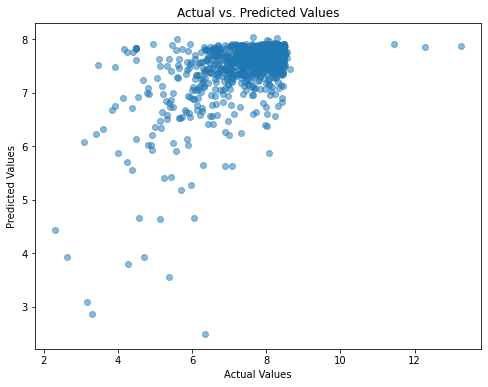

In [19]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8, 6))
plt.scatter(y_test2, predictions2, alpha=0.5)
plt.xlabel('Actual Values')
plt.ylabel('Predicted Values')
plt.title('Actual vs. Predicted Values')
plt.show()

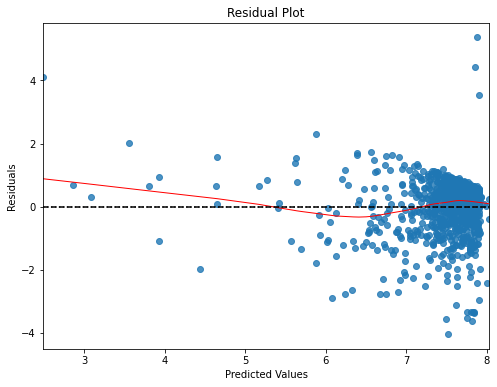

In [20]:
residuals2 = y_test2 - predictions2

plt.figure(figsize=(8, 6))
sns.residplot(x=predictions2, y=residuals2, lowess=True, line_kws={'color': 'red', 'lw': 1})
plt.xlabel('Predicted Values')
plt.ylabel('Residuals')
plt.title('Residual Plot')
plt.axhline(y=0, color='black', linestyle='--')
plt.show()

In [22]:
pip install --upgrade numpy

Note: you may need to restart the kernel to use updated packages.


In [23]:
pip install --upgrade statsmodels

  Using cached numpy-1.22.4-cp38-cp38-macosx_10_15_x86_64.whl (17.6 MB)
  Attempting uninstall: numpy
    Found existing installation: numpy 1.24.4
    Uninstalling numpy-1.24.4:
      Successfully uninstalled numpy-1.24.4
Note: you may need to restart the kernel to use updated packages.


In [21]:
import statsmodels.api as sm
import numpy as np

# Add a constant to the features for the intercept
X_train_sm = sm.add_constant(X_train2)

# Fit the model
model = sm.OLS(y_train2, X_train_sm).fit()

# Print the summary
print(model.summary())


                               OLS Regression Results                              
Dep. Variable:     Log Sales Rank: Current   R-squared:                       0.250
Model:                                 OLS   Adj. R-squared:                  0.249
Method:                      Least Squares   F-statistic:                     266.1
Date:                     Thu, 15 Feb 2024   Prob (F-statistic):          3.96e-246
Time:                             15:28:38   Log-Likelihood:                -5157.9
No. Observations:                     3994   AIC:                         1.033e+04
Df Residuals:                         3988   BIC:                         1.037e+04
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [24]:
from sklearn.linear_model import RidgeCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline

# Assuming X_train, y_train are already defined

# Create a RidgeCV model with multiple alpha values to choose from
alphas = [0.1, 1.0, 10.0, 100.0]  # Example alpha values
ridge_cv_model = make_pipeline(StandardScaler(), RidgeCV(alphas=alphas, store_cv_values=True))

# Fit the model
ridge_cv_model.fit(X_train2, y_train2)

# Optimal alpha value
optimal_alpha = ridge_cv_model.named_steps['ridgecv'].alpha_
print(f"Optimal alpha value: {optimal_alpha}")

# Predict and evaluate
predictions = ridge_cv_model.predict(X_test2)
mse = mean_squared_error(y_test2, predictions2)
print(f"Mean Squared Error with optimal alpha: {mse}")

Optimal alpha value: 100.0
Mean Squared Error with optimal alpha: 0.7785819995361138


In [25]:
import pandas as pd
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant

# Assuming 'X' is already defined from your previous code
X = modified_data_testing[['Reviews: Rating', 'Reviews: Review Count', 'Buy Box: Is FBA', 
                            "Bought in past month", 'FBA Pick&Pack Fee', 'New Offer Count: Current', 'Variation ASIN Count']]

# It's important to add a constant term for the intercept for VIF calculation
X_with_constant = add_constant(X)

# Calculate VIF for each feature
vif_data = pd.DataFrame()
vif_data["Feature"] = X_with_constant.columns
vif_data["VIF"] = [variance_inflation_factor(X_with_constant.values, i) for i in range(X_with_constant.shape[1])]

print(vif_data)

                    Feature         VIF
0                     const  131.290729
1           Reviews: Rating    1.023460
2     Reviews: Review Count    1.107708
3           Buy Box: Is FBA    1.038841
4      Bought in past month    1.173377
5         FBA Pick&Pack Fee         NaN
6  New Offer Count: Current    1.079405
7      Variation ASIN Count    1.043746


/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1782: RuntimeWarning: invalid value encountered in scalar divide
  return 1 - self.ssr/self.centered_tss


In [34]:
# Assuming 'final_data' is your current dataset
current_asins = set(modified_data['ASIN'])  # This creates a set of unique ASINs from your current dataset

In [35]:
# Load your new dataset
new_data = pd.read_csv('Keepa Jan 2024.csv')  # Adjust the path as necessary

# Filter the new dataset to only include ASINs that are in both datasets
filtered_new_dataJan = new_data[new_data['ASIN'].isin(current_asins)]


In [48]:
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Parsing Sales rank
def parse_sales_rank(row):
    if isinstance(row, str):
        parts = row.split('|')
        absolute_rank = parts[0].strip()
        top_1_percent = parts[1].strip()

        category_part = parts[-1].strip()
        category = category_part.split(';')[0].strip()

        return pd.Series([absolute_rank, top_1_percent, category])
    else:
        return pd.Series([None,None,None])

#S Split Subcategory sales rank for processing
new_columnsJan = new_data['Sales Rank: Subcategory Sales Ranks'].apply(parse_sales_rank)
new_columnsJan.columns = ['Absolute Rank', 'Top 1 Percent', 'Category']
filtered_new_dataJan = pd.concat([filtered_new_dataJan, new_columns], axis=1)


# Rempve unnessesary data
filtered_new_dataJan = filtered_new_dataJan.drop(['Sales Rank: Subcategory Sales Ranks'], axis =1)
filtered_new_dataJan = filtered_new_dataJan.drop(['Sales Rank: Reference'], axis =1)
filtered_new_dataJan = filtered_new_dataJan.drop(['Top 1 Percent'], axis =1)

# Convert Absolute Rank into numeric
filtered_new_dataJan['Absolute Rank'] = filtered_new_dataJan['Absolute Rank'].str.strip('# ')
filtered_new_dataJan['Absolute Rank'] = pd.to_numeric(filtered_new_dataJan['Absolute Rank'],errors='coerce')

#Count Variation ASIN
filtered_new_dataJan['Variation ASINs'] = filtered_new_dataJan['Variation ASINs'].fillna("")
filtered_new_dataJan['Variation ASIN Count'] = filtered_new_dataJan['Variation ASINs'].apply(lambda x: len(x.split(',')))

In [49]:
import statsmodels

# Categorizing Data
categorical_column_data = ['Buy Box Seller', 'Buy Box Used Seller', 'Buy Box Used: Condition', 'Categories: Root', 'Categories: Sub', 'Categories: Tree', 'ASIN', 'Product Codes: EAN', 'Product Codes: UPC', 'Product Codes: PartNumber', 'Parent ASIN', 'Variation ASINs', 'Freq. Bought Together', 'Type', 'Manufacturer', 'Brand', 'Product Group', 'Model', 'Variation Attributes', 'Color', 'Size', 'Edition', 'Format', 'Author', 'Contributors', 'Binding', 'Languages', 'Hazardous Materials', 'Category']
numeric_column_data = ['Sales Rank: Current', 'Amazon: 90 days OOS', 'New: 90 days OOS', 'Used: 90 days OOS', 'Sales Rank: 90 days avg.', 'Sales Rank: Drops last 90 days', 'Bought in past month','Reviews: Review Count', 'Buy Box 🚚: Current', 'Buy Box 🚚: 90 days avg.', 'Buy Box 🚚: Stock', 'Amazon: Current', 'Amazon: 90 days avg.', 'New: Current', 'New: 90 days avg.','New, 3rd Party FBA: Current','New: 90 days avg.','New, 3rd Party FBA: 90 days avg.', 'FBA Pick&Pack Fee', 'Referral Fee based on current Buy Box price', 'New, 3rd Party FBA: Current', 'New, 3rd Party FBA: 90 days avg.', 'New, Prime exclusive: Current', 'New, Prime exclusive: 90 days avg.', 'Lightning Deals: Current', 'Buy Box Used 🚚: Current', 'Buy Box Used 🚚: 90 days avg.', 'Used: Current', 'Used: 90 days avg.', 'Used, like new 🚚: Current', 'Used, like new 🚚: 90 days avg.', 'Used, very good 🚚: Current', 'Used, very good 🚚: 90 days avg.', 'Used, good 🚚: Current', 'Used, good 🚚: 90 days avg.', 'Used, acceptable 🚚: Current', 'Used, acceptable 🚚: 90 days avg.', 'Warehouse Deals: Current', 'Warehouse Deals: 90 days avg.', 'List Price: Current', 'List Price: 90 days avg.', 'Rental: Current', 'Rental: 90 days avg.', 'eBay New 🚚: Current', 'eBay New 🚚: 90 days avg.', 'eBay Used 🚚: Current', 'eBay Used 🚚: 90 days avg.', 'New Offer Count: Current', 'New Offer Count: 90 days avg.', 'Count of retrieved live offers: New, FBM', 'Used Offer Count: Current', 'Used Offer Count: 90 days avg.', 'Number of Items', 'Number of Pages', 'Package: Dimension (cm³)', 'Package: Weight (g)', 'Package: Quantity', 'Item: Dimension (cm³)', 'Item: Weight (g)', 'One Time Coupon: Absolute', 'One Time Coupon: Percentage', 'Absolute Rank', 'Variation ASIN Count']
binary_column_data = ['Buy Box: Is FBA', 'Buy Box: Unqualified', 'Lightning Deals: Upcoming Deal', 'Buy Box Used: Is FBA', 'Categories: Launchpad', 'Adult Product', 'Trade-In Eligible', 'Prime Eligible (Buy Box)', 'Subscribe and Save']

# Fill NA categorical data
for column in categorical_column_data:
    filtered_new_dataJan[column] = filtered_new_dataJan[column].fillna('Missing') 

# Encode categorical data (one hot encoding // high dimensionality)
df_categorical_encoded = pd.get_dummies(filtered_new_dataJan, columns=categorical_column_data, dtype=int)

#Convert from float to numeric for numeric data
for column in numeric_column_data:
    df_categorical_encoded[column] = pd.to_numeric(df_categorical_encoded[column], errors='coerce') 
    df_categorical_encoded[column].fillna(0)

#Encoding binary data in column to 1/0
for column in binary_column_data:
    df_categorical_encoded[column] = df_categorical_encoded[column].map(lambda x: 1 if x == 'yes' else 0)

#Encode Rating data
df_categorical_encoded['Reviews: Rating'] = pd.to_numeric(df_categorical_encoded['Reviews: Rating'], errors='coerce')

# Convert % data into numeric
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'].str.replace('%', '').astype(float)
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'].fillna(0)
df_categorical_encoded['Referral Fee %'] = df_categorical_encoded['Referral Fee %'] /100

# Convert % data into numeric
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = df_categorical_encoded['Subscribe and Save Coupon: Percentage'].str.replace('%', '', regex=False)
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = pd.to_numeric(df_categorical_encoded['Subscribe and Save Coupon: Percentage'], errors='coerce')
df_categorical_encoded['Subscribe and Save Coupon: Percentage'] = df_categorical_encoded['Subscribe and Save Coupon: Percentage']/100
df_categorical_encoded['Subscribe and Save Coupon: Percentage']= df_categorical_encoded['Subscribe and Save Coupon: Percentage'].fillna(0)

# Convert % data into numeric
df_categorical_encoded['Buy Box 🚚: 90 days OOS'] = df_categorical_encoded['Buy Box 🚚: 90 days OOS'].str.replace('%', '', regex=False)
df_categorical_encoded['Buy Box 🚚: 90 days OOS'] = pd.to_numeric(df_categorical_encoded['Buy Box 🚚: 90 days OOS'], errors='coerce')
df_categorical_encoded['Buy Box 🚚: 90 days OOS']= df_categorical_encoded['Buy Box 🚚: 90 days OOS'].fillna(0)

# Encode Time Data
time_column_data = ['Last Price Change', 'Tracking since', 'Listed since', 'Publication Date', 'Release Date']
for column in time_column_data:
    df_categorical_encoded = df_categorical_encoded.drop(column, axis=1)

 
# Remove '$' signs from data
for column in df_categorical_encoded.columns:
    if df_categorical_encoded[column].dtype == object:
        if df_categorical_encoded[column].str.contains('\$', na=False).any():
            print(f"Column '{column}' contains a '$'")
            df_categorical_encoded[column] = df_categorical_encoded[column].str.replace('\$', '', regex=True)



final_dataJan = df_categorical_encoded

Column 'New, 3rd Party FBM 🚚: Current' contains a '$'
Column 'New, 3rd Party FBM 🚚: 90 days avg.' contains a '$'


In [51]:
columns_to_fill = [
    'Sales Rank: 90 days avg.', 'Sales Rank: Drops last 90 days', 'Bought in past month',
    'Reviews: Rating', 'Reviews: Review Count', 'Ratings - Format Specific',
    'Review Count - Format Specific', 'Buy Box 🚚: Current', 'Buy Box 🚚: 90 days avg.', 'Buy Box 🚚: Stock', 
    'Amazon: Current', 'Amazon: 90 days avg.', 'Amazon: 90 days OOS',
    'New: Current', 'New: 90 days avg.', 'New: 90 days OOS', 'New, 3rd Party FBA: Current',
    'New, 3rd Party FBA: 90 days avg.', 'FBA Pick&Pack Fee', 'Referral Fee based on current Buy Box price',
    'New, 3rd Party FBM 🚚: Current', 'New, 3rd Party FBM 🚚: 90 days avg.', 'New, Prime exclusive: Current',
    'New, Prime exclusive: 90 days avg.', 'Lightning Deals: Current', 'Buy Box Used 🚚: Current', 'Buy Box Used 🚚: 90 days avg.', 'Used: Current', 'Used: 90 days avg.', 'Used: 90 days OOS',
    'Used, like new 🚚: Current', 'Used, like new 🚚: 90 days avg.', 'Used, very good 🚚: Current',
    'Used, very good 🚚: 90 days avg.', 'Used, good 🚚: Current', 'Used, good 🚚: 90 days avg.',
    'Used, acceptable 🚚: Current', 'Used, acceptable 🚚: 90 days avg.', 'Warehouse Deals: Current',
    'Warehouse Deals: 90 days avg.', 'List Price: Current', 'List Price: 90 days avg.',
    'Rental: Current', 'Rental: 90 days avg.', 'eBay New 🚚: Current', 'eBay New 🚚: 90 days avg.',
    'eBay Used 🚚: Current', 'eBay Used 🚚: 90 days avg.', 'New Offer Count: Current',
    'Count of retrieved live offers: New, FBA', 'Count of retrieved live offers: New, FBM',
    'Used Offer Count: Current', 'Used Offer Count: 90 days avg.', 'Number of Items',
    'Number of Pages', 'Package: Dimension (cm³)', 'Package: Weight (g)', 'Package: Quantity',
    'Item: Dimension (cm³)', 'Item: Weight (g)', 'One Time Coupon: Absolute',
    'One Time Coupon: Percentage', 'Absolute Rank'
]

# for column in columns_to_fill:
#     if column in final_data.columns:
#         if final_data[column].dtype == object:
#             print(column)
for column in columns_to_fill:
    if column in final_dataJan.columns:
        final_dataJan[column] = pd.to_numeric(final_dataJan[column], errors='coerce')
        column_mean = final_dataJan[column].mean()
        final_dataJan[column] = final_dataJan[column].fillna(0)
    else:
        print(f"{column} not found in DataFrame.")

In [52]:
modified_new_dataJan = final_dataJan.drop(['Title'], axis=1)
modified_new_dataJan['Log Sales Rank: Current'] = np.log(modified_new_dataJan['Sales Rank: Current'])

# Assuming 'columns_of_interest' remains the same, otherwise adjust as needed
cleaned_new_dataJan = modified_new_dataJan[columns_of_interest + ['Log Sales Rank: Current']].dropna()

# Splitting the cleaned new data into features (X) and target (y)
X_newJan = cleaned_new_dataJan[columns_of_interest]
y_newJan = cleaned_new_dataJan['Log Sales Rank: Current']

# Splitting the data into training and testing sets for the new dataset
X_train_newJan, X_test_newJan, y_train_newJan, y_test_newJan = train_test_split(X_newJan, y_newJan, test_size=0.2, random_state=42)


<ipython-input-52-941a6a4f29c6>:2: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  modified_new_dataJan['Log Sales Rank: Current'] = np.log(modified_new_dataJan['Sales Rank: Current'])


In [54]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model on the new dataset
model_newJan = LinearRegression()
model_newJan.fit(X_train_newJan, y_train_newJan)

# Predictions and evaluation on the new dataset
predictions_newJan = model_newJan.predict(X_test_newJan)
mse_newJan = mean_squared_error(y_test_newJan, predictions_newJan)
print(f"Mean Squared Error on New Dataset: {mse_newJan}")


Mean Squared Error on New Dataset: 0.9165138096596899


In [55]:
import statsmodels.api as sm
import numpy as np

# Add a constant to the features for the intercept
X_train_sm_Jan = sm.add_constant(X_train_newJan)

# Fit the model
modelJan = sm.OLS(y_train_newJan, X_train_sm_Jan).fit()

# Print the summary
print(modelJan.summary())


                               OLS Regression Results                              
Dep. Variable:     Log Sales Rank: Current   R-squared:                       0.268
Model:                                 OLS   Adj. R-squared:                  0.266
Method:                      Least Squares   F-statistic:                     128.4
Date:                     Thu, 15 Feb 2024   Prob (F-statistic):          4.23e-116
Time:                             16:13:16   Log-Likelihood:                -2415.8
No. Observations:                     1760   AIC:                             4844.
Df Residuals:                         1754   BIC:                             4876.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

/opt/anaconda3/lib/python3.8/site-packages/statsmodels/regression/linear_model.py:1966: RuntimeWarning: divide by zero encountered in scalar divide
  return np.sqrt(eigvals[0]/eigvals[-1])


In [130]:
# Load your new dataset
new_data2 = pd.read_csv('Keepa Dec 2023.csv')  # Adjust the path as necessary

# Filter the new dataset to only include ASINs that are in both datasets
filtered_new_dataDec1 = new_data2[new_data2['ASIN'].isin(current_asins)]


In [131]:
filtered_new_dataDec = filtered_new_dataDec1.drop(['Locale', 'Image'], axis =1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Parsing Sales rank
def parse_sales_rank(row):
    if isinstance(row, str):
        parts = row.split('|')
        absolute_rank = parts[0].strip()
        top_1_percent = parts[1].strip()

        category_part = parts[-1].strip()
        category = category_part.split(';')[0].strip()

        return pd.Series([absolute_rank, top_1_percent, category])
    else:
        return pd.Series([None,None,None])
    
#Count Variation ASIN
filtered_new_dataDec['Variation ASINs'] = filtered_new_dataDec['Variation ASINs'].fillna("")
filtered_new_dataDec['Variation ASIN Count'] = filtered_new_dataDec['Variation ASINs'].apply(lambda x: len(x.split(',')))

In [98]:
!pip install --upgrade pandas

In [132]:
import pandas as pd
import numpy as np

# Assuming df_encoded is your DataFrame

# List of variables you need
required_columns = [
    'Reviews: Rating', 'Reviews: Review Count', 'Buy Box: Is FBA', 
    'Bought in past month', 'FBA Pick&Pack Fee', 'New Offer Count: Current', 
    'Variation ASIN Count', 'Sales Rank: Current'
]

# Focus only on required columns for simplicity
df_model = df_encoded[required_columns].copy()

# Handling missing values - Assuming you want to fill numeric NAs with 0
# and categorical/binary with a placeholder or most common category
df_model['Buy Box: Is FBA'] = df_model['Buy Box: Is FBA'].fillna('Missing')  # Or another strategy as per your data understanding
df_model.fillna(0, inplace=True)  # For numeric columns

# Encoding binary variable 'Buy Box: Is FBA' if it's not already numeric
if df_model['Buy Box: Is FBA'].dtype == object:
    df_model['Buy Box: Is FBA'] = df_model['Buy Box: Is FBA'].map({'yes': 1, 'no': 0, 'Missing': -1}).astype(int)

# Ensuring all other numeric variables are in correct numeric format
# This step is crucial if your data has numbers stored as strings, possibly with '$' signs or commas
numeric_columns = ['Reviews: Rating', 'Reviews: Review Count', 'Bought in past month', 
                   'FBA Pick&Pack Fee', 'New Offer Count: Current', 'Variation ASIN Count', 'Sales Rank: Current']

for column in numeric_columns:
    # Removing potential formatting characters
    df_model[column] = df_model[column].astype(str).str.replace('[\$,]', '', regex=True)
    df_model[column] = pd.to_numeric(df_model[column], errors='coerce')

# Fill any conversion issues with 0 or another placeholder
df_model.fillna(0, inplace=True)

modified_new_dataDec=df_model

In [133]:
modified_new_dataDec['Log Sales Rank: Current'] = np.log(modified_new_dataDec['Sales Rank: Current'])

# Assuming 'columns_of_interest' remains the same, otherwise adjust as needed
cleaned_new_dataDec = modified_new_dataDec[columns_of_interest + ['Log Sales Rank: Current']].dropna()

# Splitting the cleaned new data into features (X) and target (y)
X_newDec = cleaned_new_dataDec[columns_of_interest]
y_newDec = cleaned_new_dataDec['Log Sales Rank: Current']

# Splitting the data into training and testing sets for the new dataset
X_train_newDec, X_test_newDec, y_train_newDec, y_test_newDec = train_test_split(X_newDec, y_newDec, test_size=0.2, random_state=42)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


In [145]:
X_train_newDec = X_train_newDec.fillna(X_train_newDec.mean())
y_test_newDec = y_test_newDec.fillna(y_test_newDec.mean()) 

In [148]:
# Replacing infinity with NaNs for imputation in features
X_train_newDec.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_newDec.fillna(X_train_newDec.mean(), inplace=True)

# Assuming y_train_newDec is a Series; if it has potential infinity values:
y_test_newDec.replace([np.inf, -np.inf], np.nan, inplace=True)
y_test_newDec.fillna(y_test_newDec.mean(), inplace=True)

In [152]:
# Replacing infinity with NaNs for imputation in features
X_train_newDec.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_newDec.fillna(X_train_newDec.mean(), inplace=True)

# Assuming y_train_newDec is a Series; if it has potential infinity values:
y_train_newDec.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train_newDec.fillna(y_train_newDec.mean(), inplace=True)

In [153]:
# Check for NaNs again
print(X_test_newDec.isnull().sum().sum(), "NaNs in X_train_newDec")
print(y_test_newDec.isnull().sum(), "NaNs in y_train_newDec")

# Check for infinity
print(np.isinf(X_test_newDec.values).sum(), "Infinities in X_train_newDec")
print(np.isinf(y_train_newDec.values).sum(), "Infinities in y_test_newDec")

0 NaNs in X_train_newDec
0 NaNs in y_train_newDec
0 Infinities in X_train_newDec
0 Infinities in y_test_newDec


In [154]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model on the new dataset
model_newDec = LinearRegression()
model_newDec.fit(X_train_newDec, y_train_newDec)

# Predictions and evaluation on the new dataset
predictions_newDec = model_newDec.predict(X_test_newDec)
mse_newDec = mean_squared_error(y_test_newDec, predictions_newDec)
print(f"Mean Squared Error on New Dataset: {mse_newDec}")

Mean Squared Error on New Dataset: 0.3352672014168462


In [156]:
import statsmodels.api as sm
import numpy as np

# Add a constant to the features for the intercept
X_train_sm_Dec = sm.add_constant(X_train_newDec)

# Fit the model
modelDec = sm.OLS(y_train_newDec, X_train_sm_Dec).fit()

# Print the summary
print(modelDec.summary())


                               OLS Regression Results                              
Dep. Variable:     Log Sales Rank: Current   R-squared:                       0.279
Model:                                 OLS   Adj. R-squared:                  0.278
Method:                      Least Squares   F-statistic:                     309.1
Date:                     Sat, 17 Feb 2024   Prob (F-statistic):          1.90e-280
Time:                             15:02:10   Log-Likelihood:                -3169.6
No. Observations:                     4000   AIC:                             6351.
Df Residuals:                         3994   BIC:                             6389.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [179]:
# Load your new dataset
new_data3 = pd.read_csv('Keepa Nov 2023.csv')  # Adjust the path as necessary

# Filter the new dataset to only include ASINs that are in both datasets
filtered_new_dataNov1 = new_data3[new_data3['ASIN'].isin(current_asins)]


In [180]:
filtered_new_dataNov = filtered_new_dataNov1.drop(['Locale', 'Image'], axis =1)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Parsing Sales rank
def parse_sales_rank(row):
    if isinstance(row, str):
        parts = row.split('|')
        absolute_rank = parts[0].strip()
        top_1_percent = parts[1].strip()

        category_part = parts[-1].strip()
        category = category_part.split(';')[0].strip()

        return pd.Series([absolute_rank, top_1_percent, category])
    else:
        return pd.Series([None,None,None])
    
#Count Variation ASIN
filtered_new_dataNov['Variation ASINs'] = filtered_new_dataNov['Variation ASINs'].fillna("")
filtered_new_dataNov['Variation ASIN Count'] = filtered_new_dataNov['Variation ASINs'].apply(lambda x: len(x.split(',')))

In [181]:
import pandas as pd
import numpy as np

# Assuming df_encoded is your DataFrame

# List of variables you need
required_columns = [
    'Reviews: Rating', 'Reviews: Review Count', 'Buy Box: Is FBA', 
    'Bought in past month', 'FBA Pick&Pack Fee', 'New Offer Count: Current', 
    'Variation ASIN Count', 'Sales Rank: Current'
]

# Focus only on required columns for simplicity
df_model2 = df_encoded[required_columns].copy()

# Handling missing values - Assuming you want to fill numeric NAs with 0
# and categorical/binary with a placeholder or most common category
df_model2['Buy Box: Is FBA'] = df_model2['Buy Box: Is FBA'].fillna('Missing')  # Or another strategy as per your data understanding
df_model2.fillna(0, inplace=True)  # For numeric columns

# Encoding binary variable 'Buy Box: Is FBA' if it's not already numeric
if df_model2['Buy Box: Is FBA'].dtype == object:
    df_model2['Buy Box: Is FBA'] = df_model2['Buy Box: Is FBA'].map({'yes': 1, 'no': 0, 'Missing': -1}).astype(int)

# Ensuring all other numeric variables are in correct numeric format
# This step is crucial if your data has numbers stored as strings, possibly with '$' signs or commas
numeric_columns = ['Reviews: Rating', 'Reviews: Review Count', 'Bought in past month', 
                   'FBA Pick&Pack Fee', 'New Offer Count: Current', 'Variation ASIN Count', 'Sales Rank: Current']

for column in numeric_columns:
    # Removing potential formatting characters
    df_model2[column] = df_model2[column].astype(str).str.replace('[\$,]', '', regex=True)
    df_model2[column] = pd.to_numeric(df_model2[column], errors='coerce')

# Fill any conversion issues with 0 or another placeholder
df_model2.fillna(0, inplace=True)

modified_new_dataNov=df_model

In [182]:
modified_new_dataNov['Log Sales Rank: Current'] = np.log(modified_new_dataNov['Sales Rank: Current'])

# Assuming 'columns_of_interest' remains the same, otherwise adjust as needed
cleaned_new_dataNov = modified_new_dataNov[columns_of_interest + ['Log Sales Rank: Current']].dropna()

# Splitting the cleaned new data into features (X) and target (y)
X_newNov = cleaned_new_dataNov[columns_of_interest]
y_newNov = cleaned_new_dataNov['Log Sales Rank: Current']

# Splitting the data into training and testing sets for the new dataset
X_train_newNov, X_test_newNov, y_train_newNov, y_test_newNov = train_test_split(X_newNov, y_newNov, test_size=0.2, random_state=42)

/opt/anaconda3/lib/python3.8/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


X_train_newNov = X_train_newNov.fillna(X_train_newNov.mean())
y_test_newNov= y_test_newNov.fillna(y_test_newNov.mean()) 

In [188]:
# Replacing infinity with NaNs for imputation in features
X_train_newNov.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_newNov.fillna(X_train_newNov.mean(), inplace=True)

# Assuming y_train_newDec is a Series; if it has potential infinity values:
y_test_newNov.replace([np.inf, -np.inf], np.nan, inplace=True)
y_test_newNov.fillna(y_test_newNov.mean(), inplace=True)

<ipython-input-188-d4bcd9cc0a8f>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_newNov.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-188-d4bcd9cc0a8f>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_newNov.fillna(X_train_newNov.mean(), inplace=True)


In [185]:
# Replacing infinity with NaNs for imputation in features
X_train_newNov.replace([np.inf, -np.inf], np.nan, inplace=True)
X_train_newNov.fillna(X_train_newNov.mean(), inplace=True)

# Assuming y_train_newDec is a Series; if it has potential infinity values:
y_train_newNov.replace([np.inf, -np.inf], np.nan, inplace=True)
y_train_newNov.fillna(y_train_newNov.mean(), inplace=True)

<ipython-input-185-e86820c84539>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_newNov.replace([np.inf, -np.inf], np.nan, inplace=True)
<ipython-input-185-e86820c84539>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_train_newNov.fillna(X_train_newNov.mean(), inplace=True)


In [189]:
# Check for NaNs again
print(X_test_newNov.isnull().sum().sum(), "NaNs in X_train_newDec")
print(y_test_newNov.isnull().sum(), "NaNs in y_train_newDec")

# Check for infinity
print(np.isinf(X_test_newNov.values).sum(), "Infinities in X_train_newDec")
print(np.isinf(y_train_newNov.values).sum(), "Infinities in y_test_newDec")

0 NaNs in X_train_newDec
0 NaNs in y_train_newDec
0 Infinities in X_train_newDec
0 Infinities in y_test_newDec


In [190]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

# Train the model on the new dataset
model_newNov = LinearRegression()
model_newNov.fit(X_train_newNov, y_train_newNov)

# Predictions and evaluation on the new dataset
predictions_newNov = model_newNov.predict(X_test_newNov)
mse_newNov = mean_squared_error(y_test_newNov, predictions_newNov)
print(f"Mean Squared Error on New Dataset: {mse_newNov}")

Mean Squared Error on New Dataset: 0.3352672014168462


In [191]:
import statsmodels.api as sm
import numpy as np

# Add a constant to the features for the intercept
X_train_sm_Nov = sm.add_constant(X_train_newNov)

# Fit the model
modelNov = sm.OLS(y_train_newNov, X_train_sm_Nov).fit()

# Print the summary
print(modelNov.summary())


                               OLS Regression Results                              
Dep. Variable:     Log Sales Rank: Current   R-squared:                       0.279
Model:                                 OLS   Adj. R-squared:                  0.278
Method:                      Least Squares   F-statistic:                     309.1
Date:                     Sat, 17 Feb 2024   Prob (F-statistic):          1.90e-280
Time:                             15:25:26   Log-Likelihood:                -3169.6
No. Observations:                     4000   AIC:                             6351.
Df Residuals:                         3994   BIC:                             6389.
Df Model:                                5                                         
Covariance Type:                 nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
-------------------------------------------------------------------

In [ ]:
modified_data_testing.head()